In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

Text(0.5, 1.0, 'Small Image')

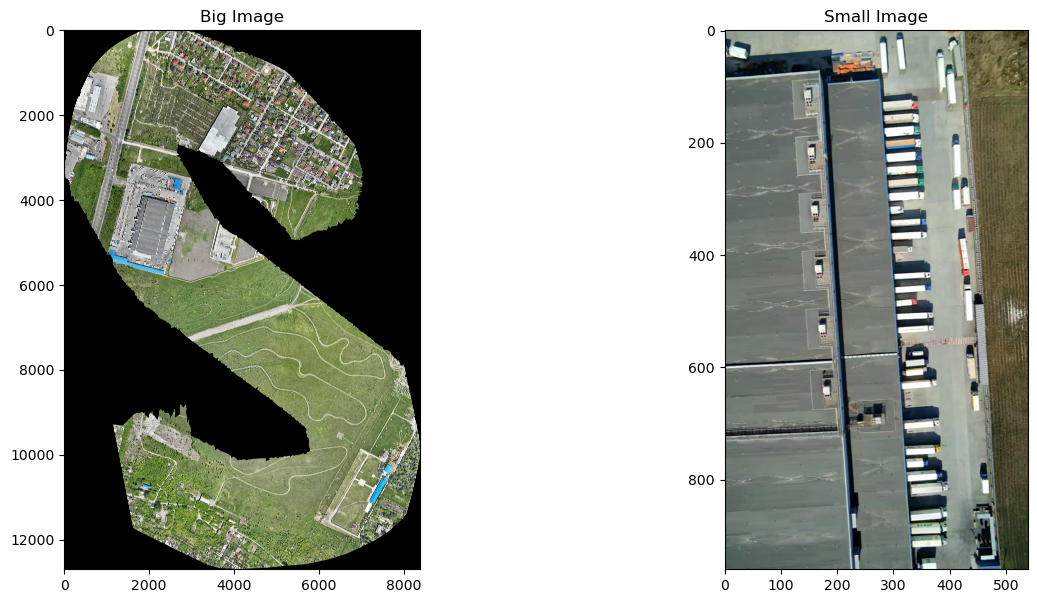

In [2]:
big_image = cv2.imread(os.path.join('img','big.tif'), cv2.IMREAD_COLOR)
small_image = cv2.imread(os.path.join('img','small.png'), cv2.IMREAD_COLOR)
plt.figure(figsize=[15,7])
plt.subplot(121); plt.imshow(big_image[:,:,::-1]); plt.title('Big Image')
plt.subplot(122); plt.imshow(small_image[:,:,::-1]); plt.title('Small Image')

I have 2 images of different scales that need to be matched. After careful visual inspection, it becomes clear that the small picture is not a direct crop of the larger one, they were taken at different times (different numbers of cars parked next to the building) and at different angles (the building in the bigger picture is oriented at approximately 80 degrees with regard to horizontal axis while the building in the smaller picture is oriented at approximately 95 degrees to the same axis). I will test a couple of methods for image matching from the OpenCV library. The first and easiest one to try is the template matching approach (where a smaller image is slid across a bigger image to calculate a similarity score at each position). It is not robust to different scales and rotations, but I will try it as a benchmark.

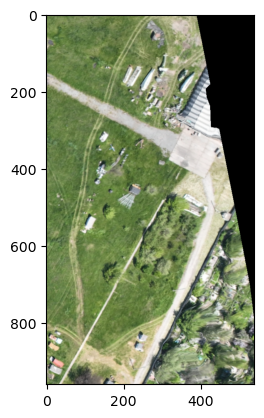

In [3]:
# turn pictures into grayscale to reduce the complexity of computations
large_gray = cv2.cvtColor(big_image, cv2.COLOR_BGR2GRAY)
small_gray = cv2.cvtColor(small_image, cv2.COLOR_BGR2GRAY)
# find the height and width of the smaller image to further crop the larger one
h, w = small_gray.shape
# use correlation coefficient as a similarity metric
search = cv2.matchTemplate(large_gray, small_gray, cv2.TM_CCOEFF_NORMED)
# get top corner with largest correlation, find bottom corner and crop
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(search)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cropped_region = big_image[top_left[1]:bottom_right[1], 
                           top_left[0]:bottom_right[0]]
plt.imshow(cropped_region[:,:,::-1])

As was expected the method is not effective, the chosen region is far from the real location. The next approach to try is feature-based matching (it detects features such as corners and edges on both pictures and matches those). The method is considered to be more robust to lighting conditions, difference in scale, rotation, and perspective. It should work better for this case.

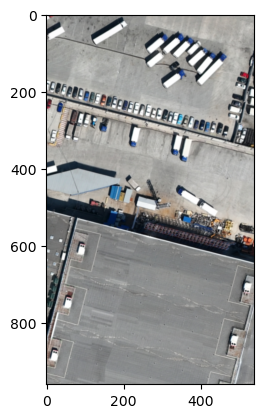

In [4]:
# use ORB algorithm
orb = cv2.ORB_create()
# detect keypoints on both pictures
keypoints1, descriptors1 = orb.detectAndCompute(small_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(large_gray, None)
# match discriptors, compare those
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) # since ORB is binary Hamming distance is used
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key=lambda x: x.distance) # sort by distance
# get coordinates of matched points
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
# get corners of the small image and transform into coord. system of the target image
pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, matrix)
top_left = dst[0][0]
# crop the image
x, y = map(int, top_left)
cropped_region = big_image[y:y+h, x:x+w]
plt.imshow(cropped_region[:,:,::-1])

This region is much closer to the target image, so I will use this method to get the top left corner. In order to get a closer match I will tweak the hyperparameters in ORB a little.

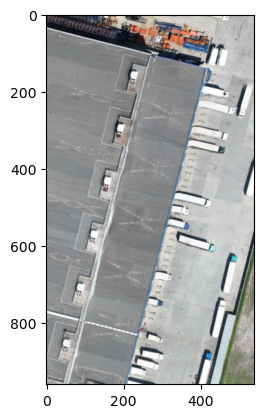

In [5]:
# convert images to grayscale
small_gray = cv2.cvtColor(small_image, cv2.COLOR_BGR2RGB)
large_gray = cv2.cvtColor(big_image, cv2.COLOR_BGR2RGB)
# enhance contrast using CLAHE to sharpen the image
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
small_gray = clahe.apply(cv2.cvtColor(small_gray, cv2.COLOR_RGB2GRAY))
large_gray = clahe.apply(cv2.cvtColor(large_gray, cv2.COLOR_RGB2GRAY))

orb = cv2.ORB_create(
        nfeatures=20000, # increased number of features
        scaleFactor=1.018, # decreased scale for more precise detection
        nlevels=12, # increased for scale handling
        edgeThreshold=25, # decreased to get better edge architectural details
        firstLevel=0, 
        WTA_K=2,
        patchSize=31,
        fastThreshold=10 # decreased to get more corners
    )
keypoints1, descriptors1 = orb.detectAndCompute(small_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(large_gray, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) 
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key=lambda x: x.distance) 
good_matches = matches[:int(len(matches) * 0.15)]  # Take top 15% of matches

src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 
                                    ransacReprojThreshold=5.0,
                                    maxIters=2000,
                                    confidence=0.995)

pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, matrix)

top_left = dst[0][0]
x, y = map(int, top_left)
cropped_region = big_image[y:y+h, x:x+w]
plt.imshow(cropped_region[:,:,::-1])

The received picture now matches the exact area on the small image template. But since the hyperparameters were tweaked specifically to get a better match for a single pair of images, we have an overfitting case. This means that I achieved a much better match for this case, but it might not generalize well for other similar cases. Since the task was to find the coordinate for this specific pair of pictures, I will stick to the code produced above

In [6]:
def find_top_corner(small_image, big_image):
    small_gray = cv2.cvtColor(small_image, cv2.COLOR_BGR2RGB)
    large_gray = cv2.cvtColor(big_image, cv2.COLOR_BGR2RGB)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    small_gray = clahe.apply(cv2.cvtColor(small_gray, cv2.COLOR_RGB2GRAY))
    large_gray = clahe.apply(cv2.cvtColor(large_gray, cv2.COLOR_RGB2GRAY))

    orb = cv2.ORB_create(
            nfeatures=20000, 
            scaleFactor=1.018, 
            nlevels=12, 
            edgeThreshold=25, 
            firstLevel=0, 
            WTA_K=2,
            patchSize=31,
            fastThreshold=10
        )
    keypoints1, descriptors1 = orb.detectAndCompute(small_gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(large_gray, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) 
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance) 
    good_matches = matches[:int(len(matches) * 0.15)]

    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 
                                      ransacReprojThreshold=5.0,
                                      maxIters=2000,
                                      confidence=0.995)

    pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, matrix)
    return dst[0][0]

In [7]:
find_top_corner(small_image, big_image)

array([2196.2341, 3970.7712], dtype=float32)